In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

### Definition of the model

In [3]:
# The SIR model differential equations.
def deriv(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

### Integration of the differential equations

In [4]:
def time_evo(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### Show the result

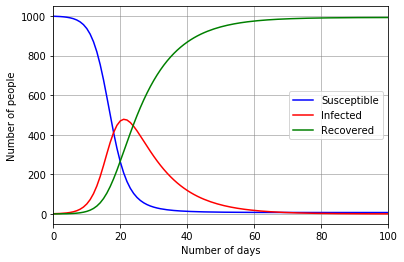

In [5]:
fin_result=time_evo(1000,0.5,0.1)

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]

plt.plot(t, s_vec, 'b', label='Susceptible')
plt.plot(t, i_vec, 'r', label='Infected')
plt.plot(t, r_vec, 'g', label='Recovered')
#plt.plot(t, m_vec, 'k', label='Deaths')
#plt.plot(t, i_vec+r_vec, color='orange',linestyle='--', label='Infected + Recovered')
plt.legend(loc=5)
#plt.yscale('log')
#plt.ylim(0.5,3000)
plt.xlim(0,100)
plt.xlabel('Number of days')
plt.ylabel('Number of people')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('output/plotsir.png',dpi=300)
plt.show()

#print(s_vec+i_vec+r_vec+m_vec)

# All-in-one

In [8]:
vector_regions = ['nord', 'centro', 'sud', 'isole']#,'nolombardia','lombardia']
for r in range(len(vector_regions)):
    fit_region = vector_regions[r]

    if fit_region =='nord':
        region    = ['Lombardia','Veneto','Emilia-Romagna','Liguria','Piemonte','Valle d\'Aosta','P.A. Trento','P.A. Bolzano','Friuli Venezia Giulia'] 
        n_regions = len(region)
    elif fit_region =='centro':
        region    = ['Toscana','Marche','Umbria','Lazio','Abruzzo','Molise']
        n_regions = len(region)
    elif fit_region =='sud':
        region    = ['Puglia','Calabria','Basilicata','Campania']
        n_regions = len(region)
    elif fit_region =='isole':
        region    = ['Sicilia','Sardegna']
        n_regions = len(region)
        
    elif  fit_region =='italia': 
        region    = 'Italia'
        n_regions = 1
    elif fit_region =='nolombardia':
        region    = ['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna','Friuli Venezia Giulia','Lazio','Liguria','Marche','Molise','Piemonte','Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto']
        n_regions = len(region)    
    elif fit_region =='lombardia':
        region    = ['Lombardia']
        n_regions = 1
    print(fit_region)

    
    popolation_regions = np.array([  1304970,      559084,        533050,   1947131,   5801692,         4459477,                1215220,5879082, 1550640,    10060574,  1525271,  305617,    4356406, 4029053, 1639591,  4999891,  3729641,       541380,  882015,          125666, 4905854])
    name_regions       = np.array(['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna','Friuli Venezia Giulia','Lazio','Liguria','Lombardia','Marche','Molise','Piemonte','Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto'])
    regions            = np.vstack((name_regions,popolation_regions))

    mask_reg = []
    for i in range(n_regions):
        mask_reg.append(regions[0,:] == region[i])
    mask_reg = np.array(mask_reg)
    
    data = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
    N = 0
    xxx = []
    yyy = []
    zzz = []
    for i in range(n_regions):
        N += int(regions[1,mask_reg[i]])
        mask_REG=data['denominazione_regione']==region[i]
        xxx.append(data.loc[mask_REG,'totale_casi'])
        yyy.append(data.loc[mask_REG,'deceduti'])
        zzz.append(data.loc[mask_REG,'dimessi_guariti'])

    ydata       = np.array(np.sum(xxx,axis=0))
    ydata_death = np.array(np.sum(yyy,axis=0))
    ydata_rec   = np.array(np.sum(zzz,axis=0))
    ydata_inf   = ydata-ydata_rec-ydata_death
    xdata       = pd.to_numeric(range(ydata.shape[0]))
    today       = len(xdata)
    
    def minimizer(R0,t1=today-7,t2=today):
    
        #true data
        ydata_inf_2=np.array(ydata_inf[t1:t2])
        xdata_2=np.arange(0,len(ydata_inf_2))

        #model
        fin_result=time_evo(N,0.1*R0,0.1,I0=ydata_inf_2[0])
        i_vec=fin_result[2]
        i_vec_2=i_vec[0:len(xdata_2)]

        #average error
        error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100

        return error

    minimizer_vec=np.vectorize(minimizer)

    xgrid    = np.arange(0.1,1.3,0.01)
    ygrid    = minimizer_vec(xgrid)
    r0_ideal = round(xgrid[np.argmin(ygrid)],2)
    print('r0_ideal for the '+fit_region+': ',r0_ideal)

    ydata_inf_2 = np.array(ydata_inf[today-5:today])
    xdata_2     = np.arange(0,len(ydata_inf_2))
    print('ydata_inf.shape '+fit_region+': ',ydata_inf.shape)
    print('ydata_inf for the '+fit_region+': ',ydata_inf)
    print('ydata_inf_2 for the '+fit_region+': ',ydata_inf_2)

    fin_result  = time_evo(N,0.1*r0_ideal,0.1,I0=ydata_inf_2[0])

    t=fin_result[0]
    s_vec=fin_result[1]
    i_vec=fin_result[2]
    r_vec=fin_result[3]
    
    
    def minimizer_gen(t1,t2):

        xgrid=np.arange(0.1,7.2,0.1)
        ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
        r0_ideal=round(xgrid[np.argmin(ygrid)],2)

        return r0_ideal
    
    r0_time=[]
    
    for i in range(today-6):
        min_val=minimizer_gen(i,i+7)
        r0_time.append(min_val)
        print(i,min_val)
      
    if fit_region =='nord':
        r0_time_nord=np.array(r0_time)
    elif fit_region =='centro':
        r0_time_centro=np.array(r0_time)
    elif fit_region =='sud':
        r0_time_sud=np.array(r0_time)
    elif fit_region =='isole':
        r0_time_isole=np.array(r0_time)
    elif fit_region =='nolombardia':
        r0_time_nolombardia=np.array(r0_time)
    elif fit_region =='lombardia':
        r0_time_lombardia=np.array(r0_time)
    r0_time.clear()
    

nord
r0_ideal for the nord:  1.07
ydata_inf.shape nord:  (56,)
ydata_inf for the nord:  [  219   304   379   576   797  1004  1502  1751  2114  2485  2973  3490
  4498  5608  7050  7406  9230 11127 12837 15062 17234 19254 21543 23445
 26893 30373 34200 37022 39950 42647 45066 48373 51748 54074 56732 57456
 58760 60934 62369 63856 66273 68600 69965 70435 71302 72662 73715 75310
 77015 78155 78502 79568 80301 80585 81351 81655]
ydata_inf_2 for the nord:  [79568 80301 80585 81351 81655]
0 4.2
1 4.0
2 4.4
3 3.8
4 3.5
5 3.5
6 2.7
7 2.7
8 2.7
9 3.0
10 3.1
11 3.3
12 2.8
13 2.7
14 2.5
15 2.8
16 2.6
17 2.4
18 2.3
19 2.2
20 2.1
21 2.1
22 2.1
23 2.2
24 2.0
25 1.9
26 1.7
27 1.7
28 1.6
29 1.6
30 1.6
31 1.5
32 1.4
33 1.3
34 1.2
35 1.3
36 1.3
37 1.3
38 1.3
39 1.3
40 1.2
41 1.1
42 1.1
43 1.2
44 1.2
45 1.2
46 1.2
47 1.2
48 1.1
49 1.1
50 1.1
51 1.1
centro
r0_ideal for the centro:  1.08
ydata_inf.shape centro:  (56,)
ydata_inf for the centro:  [    2     4     3     6    14    26    47    57   105   163 

/Users/nestrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


4 4.9
5 3.1
6 3.6
7 4.2
8 3.2
9 4.3
10 3.7
11 3.3
12 3.6
13 2.7
14 2.8
15 3.2
16 3.2
17 3.0
18 3.1
19 2.8
20 2.9
21 3.0
22 2.7
23 3.0
24 2.5
25 2.2
26 2.0
27 1.9
28 1.8
29 2.0
30 2.0
31 2.0
32 1.9
33 1.7
34 1.7
35 1.5
36 1.6
37 1.5
38 1.5
39 1.3
40 1.3
41 1.3
42 1.2
43 1.3
44 1.2
45 1.2
46 1.1
47 1.1
48 1.1
49 1.1
50 1.0
51 1.1
isole
r0_ideal for the isole:  1.1
ydata_inf.shape isole:  (56,)
ydata_inf for the isole:  [   0    3    3    2    2    2    7    5    6   18   18   27   38   62
   71   80  118  150  169  197  254  308  341  399  525  667  779  923
 1024 1194 1348 1557 1654 1811 1912 2030 2149 2219 2324 2408 2515 2589
 2634 2680 2733 2818 2843 2889 2933 2964 2971 2951 2973 3011 3052 3066]
ydata_inf_2 for the isole:  [2951 2973 3011 3052 3066]
0 0.1
1 0.1
2 0.1
3 3.3
4 3.8
5 5.6
6 0.2
7 5.2
8 6.0
9 3.5
10 4.7
11 4.2
12 3.8
13 3.2
14 3.2
15 3.5
16 2.8
17 2.8
18 2.8
19 2.8
20 2.5
21 2.8
22 3.1
23 3.2
24 2.9
25 2.5
26 2.4
27 2.3
28 2.4
29 2.1
30 2.0
31 1.7
32 1.7
33 1.5
34 1.5
35 1

In [ ]:
df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time_nord)),unit='D',origin='2020-03-01'))
df_r0['nord']   = r0_time_nord
df_r0['centro'] = r0_time_centro
df_r0['sud']    = r0_time_sud
df_r0['isole']  = r0_time_isole
#df_r0['nolombardia']    = r0_time_nolombardia
#df_r0['lombardia']      = r0_time_lombardia


df_r0.columns   = ['Data','nord','centro','sud','isole']#,'nolombardia','lombardia']

In [ ]:
df_r0.to_csv('output/r0_regions_work.csv',index=False)

In [ ]:
plt.plot(r0_time_isole)

# Single region

In [ ]:
region    = ['Molise']
n_regions = 1

popolation_regions = np.array([  1304970,      559084,        533050,   1947131,   5801692,         4459477,                1215220,5879082, 1550640,    10060574,  1525271,  305617,    4356406, 4029053, 1639591,  4999891,  3729641,       541380,  882015,          125666, 4905854])
name_regions       = np.array(['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna','Friuli Venezia Giulia','Lazio','Liguria','Lombardia','Marche','Molise','Piemonte','Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto'])
regions            = np.vstack((name_regions,popolation_regions))

mask_reg = []
for i in range(n_regions):
    mask_reg.append(regions[0,:] == region[i])
mask_reg = np.array(mask_reg)

data = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
N = 0
xxx = []
yyy = []
zzz = []
for i in range(n_regions):
    N += int(regions[1,mask_reg[i]])
    mask_REG=data['denominazione_regione']==region[i]
    xxx.append(data.loc[mask_REG,'totale_casi'])
    yyy.append(data.loc[mask_REG,'deceduti'])
    zzz.append(data.loc[mask_REG,'dimessi_guariti'])

ydata       = np.array(np.sum(xxx,axis=0))
ydata_death = np.array(np.sum(yyy,axis=0))
ydata_rec   = np.array(np.sum(zzz,axis=0))
ydata_inf   = ydata-ydata_rec-ydata_death
xdata       = pd.to_numeric(range(ydata.shape[0]))
today       = len(xdata)

def minimizer(R0,t1=today-5,t2=today):

    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))

    #model
    fin_result=time_evo(N,0.1*R0,0.1,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]

    #average error
    error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100

    return error

minimizer_vec=np.vectorize(minimizer)

xgrid    = np.arange(1,1.3,0.01)
ygrid    = minimizer_vec(xgrid)
r0_ideal = round(xgrid[np.argmin(ygrid)],2)
print('r0_ideal for the '+region[0]+': ',r0_ideal)

ydata_inf_2 = np.array(ydata_inf[today-5:today])
xdata_2     = np.arange(0,len(ydata_inf_2))
print('ydata_inf.shape '+region[0]+': ',ydata_inf.shape)
print('ydata_inf for the '+region[0]+': ',ydata_inf)
print('ydata_inf_2 for the '+region[0]+': ',ydata_inf_2)

fin_result  = time_evo(N,0.1*r0_ideal,0.1,I0=ydata_inf_2[0])

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]


def minimizer_gen(t1,t2):

    xgrid=np.arange(1,7.2,0.01)
    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]

for i in range(today-4):
    min_val=minimizer_gen(i,i+5)
    r0_time.append(min_val)
    print(i,min_val)


r0_time_region=np.array(r0_time)

r0_time.clear()

df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time_region)),unit='D',origin='2020-02-28'))
df_r0['molise']   = r0_time_region
df_r0.columns   = ['Data','molise']

df_r0.to_csv('output/r0_'+region[0]+'.csv',index=False)
